This notebook is to work on developing and testing reliable preprocessing steps for use as input to clustering algorithms.

Initial Transforms:
- KNN
- Topological Overlap
- Pearson Correlation
- Log transform
- Percentile cutoff (on edges)

Each transform will also be tested to see how well it helps emphasize functional linkages. The main evaluations are: 
- What is the correlation between network weight and GO distance (as defined by Jaccard or Topological Overlap)
- Given a test sub-network composed of non-overlapping GO terms, how high is the modularity of the gold-standard clustering?

In [5]:
import numpy as np
import pandas as pd

import sys
sys.path.append('../')
from lib.Dab import Dab

import igraph

In [6]:
import lib.clustering
reload(lib.clustering)
from lib.clustering import *

As a reminder about the GraphTransform class given in the API:


#### GraphTransform
*Properties*

   - name: a printable name of the graph transform 

*Public Methods*

   - `__init__(self, **kwargs)`: initialize the transformer with optional parameters
   - `transform(self, dab, **kwargs)`: returns a new Dab object formed by applying the transform to its argument. Weights should range from 0 to 1 in the transformed Dab, with 1 corresponding to strongly connected genes and 0 corresponding to unconnected genes

### KNN Transform

The K-Nearest-Neighbors transform for genes i and j is equal to the size of the intersection of each gene's k nearest neighbors, divided by k. Nearest neighbor is defined by highest network weight, and the whole transform is paramaterized on the variable "k"

In [7]:
class KNN(GraphTransform):
    def __init__(self, k, **kwargs):
        self.name = "KNN(%d)" % k
        self.k = k
    def transform(self, dab, **kwargs):
        n = len(dab.genes)
        # Neighbors[i] holds the list of genes that have gene i as a k-nearest-neighbor 
        neighbors = [[] for i in range(n)]
        for i in range(n):
            knn = np.argpartition(dab.weights[i], -self.k)[-self.k:]
            for j in knn:
                neighbors[j].append(i)
        # Construct the Dab to return
        out = Dab()
        out.genes = list(dab.genes)
        out.weights = np.zeros((n,n), dtype=np.float64)
        
        for i in range(n):
            out.weights[np.ix_(neighbors[i], neighbors[i])] += 1.0/self.k
        # Zero-out the diagonal
        out.weights[range(n), range(n)] = 0
        return out
    
    # Use a simpler algorithm to get a value for positions i and j
    def test_position(self, dab, i, j):
        x = dab.weights[i]
        y = dab.weights[j]
        #Test that the partition to get k largest works
        knn_x = np.argpartition(x, -self.k)[-self.k:]
        knn_y = np.argpartition(y, -self.k)[-self.k:]
        knn_set_x = set(knn_x)
        knn_set_y = set(knn_y)
        m_x = min(x[knn_x])
        m_y = min(y[knn_y])
        for i in range(len(x)):
            if i not in knn_set_x:
                assert x[i] <= m_x
            if i not in knn_set_y:
                assert y[i] <= m_y
        return len(knn_set_x & knn_set_y)/float(self.k)

In [8]:
def test_correctness(transformer, d, test_count=1000):
    out = transformer.transform(d)
    max_deviation = 0.0
    total_deviation = 0
    max_idxs = (-1,-1)
    for i in range(test_count):
        x, y = np.random.randint(len(d.genes), size=2)
        while x == y:
            x, y = np.random.randint(len(d.genes), size=2)
        dev = abs(transformer.test_position(d, x, y) - out.weights[x,y])
        total_deviation += dev
        if dev > max_deviation:
            max_deviation = dev
            max_idxs = (x, y)
    print "Average deviation: %f\tMax deviation: %f at (%d,%d)" % \
            (total_deviation/float(test_count), max_deviation, max_idxs[0], max_idxs[1])

def gen_random_dab(n):
    d = Dab()
    d.genes = [str(i) for i in range(n)]
    d.weights = np.random.random((n,n))
    d.weights[range(n), range(n)] = 0
    for i in range(1, n):
        d.weights[i:,i-1] = d.weights[i-1,i:]
    return d

In [9]:
print "Testing KNN correctness (small example)"
test_correctness(KNN(5), gen_random_dab(15))
print "Testing KNN correctness (large example)"
test_correctness(KNN(100), gen_random_dab(1000))

Testing KNN correctness (small example)
Average deviation: 0.000000	Max deviation: 0.000000 at (14,13)
Testing KNN correctness (large example)
Average deviation: 0.000000	Max deviation: 0.000000 at (721,165)


### Topological Overlap

This implements Topological Overlap as defined by Steve Horvath. Specifically this is GTOM1, linked here: https://labs.genetics.ucla.edu/horvath/GTOM/old/GTOM_tech_report.pdf

In [10]:
class TopoOverlap(GraphTransform):
    name = "Topological Overlap"
        
    # Perform the transform on raw matrices, where
    # A is the adjacency matrix and A2 = A*A
    def transform_matrices(self, A, A2):
        n = len(A)
        num = A2 + A
        # Zero-out the diagonal of the matrix
        num[range(n), range(n)] = 0
        deg = np.sum(A, axis=1) #This appears to give better performance than axis=0
        d1 = np.reshape(deg, (n,1))
        d2 = np.reshape(deg, (1,n))
        denom = np.minimum(d1, d2) + 1 - A
        return num / denom
        
    def transform(self, dab, **kwargs):
        n = len(dab.genes)
        A = dab.weights
        A2 = np.dot(dab.weights, dab.weights.T)
        
        # Construct the Dab to return
        out = Dab()
        out.genes = list(dab.genes)
        out.weights = self.transform_matrices(A, A2)
        return out
        
    # Use a simpler algorithm to get a value for positions i and j
    def test_position(self, dab, i, j):
        n = len(dab.genes)
        num = 0.0
        for u in range(n):
            if u == i or u == j:
                continue
            num += dab.weights[i, u] * dab.weights[j, u]
        num += dab.weights[i, j]
        denom = min(sum(dab.weights[i]), sum(dab.weights[j])) + 1 - dab.weights[i,j]
        return num/denom
        

In [7]:
print "Testing Topological Overlap correctness (small example)"
test_correctness(TopoOverlap(), gen_random_dab(15))
print "Testing Topological Overlap correctness (large example)"
test_correctness(TopoOverlap(), gen_random_dab(1000))

Testing Topological Overlap correctness (small example)
Average deviation: 0.000000	Max deviation: 0.000000 at (14,12)
Testing Topological Overlap correctness (large example)
Average deviation: 0.000000	Max deviation: 0.000000 at (265,124)


### Pearson Correlation

This is a pretty standard Pearson Correlation Coefficient, with the one twist that I've added some tricks to exclude self-edges from the correlation calculations (so A[i,i] does not end up getting counted in the correlation). Note that it returns (correlation + 1)/2 so that the range of output is in [0,1]

In [11]:
class Pearson(GraphTransform):
    name = "Pearson"
        
    # Perform the transform on raw matrices, where
    # A is the adjacency matrix and A2 = A*A
    # Note: this implemtation is tear-inducingly memory inefficient, but it's what
    # is possible in python (main problem is inefficient loops)
    def transform_matrices(self, A, A2):
        n = len(A)
        #Return a matrix A where A[i][j] = sum(mat[i][:] - mat[i][j])
        #This is useful in calculating the right averages for pairwise correlations
        #while ignoring the lack of self-edges
        def rowsum(mat):
            return  mat.sum(axis=1).reshape((mat.shape[0], 1)) - mat
        
        B = rowsum(A)
        
        # cov[i,j] = covariance of rows A[i], A[j] 
        # after removing comparisons between A[i,i] and A[i,j], etc.
        cov = A2 - (B * B.T) / (n-2)   
        
        # dev[i,j] = standard deviation of row A[i], when the entry A[i,j] is 
        # removed from consideration
        dev = (rowsum(A**2) - (B**2) / (n-2))**.5
        
        # Shift the correlation values to be in the range (0,1)
        return (1 + cov / (dev * dev.T)) / 2
        
    def transform(self, dab, **kwargs):
        n = len(dab.genes)
        A = dab.weights
        A2 = np.dot(dab.weights, dab.weights.T)
        
        # Construct the Dab to return
        out = Dab()
        out.genes = list(dab.genes)
        out.weights = self.transform_matrices(A, A2)
        # Zero out the diagonal
        out.weights[range(n), range(n)] = 0
        return out
        
    # Use a simpler algorithm to get a value for positions i and j
    def test_position(self, dab, i, j):
        return (np.corrcoef(
            np.delete(dab.weights[i,:], [i,j]),
            np.delete(dab.weights[j,:], [i,j])
        )[1,0] + 1)/2
        

In [9]:
print "Testing Pearson correctness (small example)"
small = gen_random_dab(15)
test_correctness(Pearson(), small)
print "Testing Pearson correctness (large example)"
test_correctness(Pearson(), gen_random_dab(1000))

Testing Pearson correctness (small example)
Average deviation: 0.000000	Max deviation: 0.000000 at (11,8)
Testing Pearson correctness (large example)
Average deviation: 0.000000	Max deviation: 0.000000 at (803,355)


### Cosine Distance

Cosine distance is a lot like Pearson Correlation, and I suspect it won't work as well

In [12]:
class Cosine(GraphTransform):
    name = "Cosine"
        
    # Perform the transform on raw matrices, where
    # A is the adjacency matrix and A2 = A*A
    # Note: this implemtation is tear-inducingly memory inefficient, but it's what
    # is possible in python (main problem is inefficient loops)
    def transform_matrices(self, A, A2):
        n = len(A)
        #Return a matrix A where A[i][j] = sum(mat[i][:] - mat[i][j])
        #This is useful in calculating the right averages for pairwise correlations
        #while ignoring the lack of self-edges
        def rowsum(mat):
            return  mat.sum(axis=1).reshape((mat.shape[0], 1)) - mat
        
        denom = rowsum(A**2)**.5
        # Shift the cosine values to be in the range (0, 1)
        return (1 + A2 / (denom * denom.T)) / 2
        
    def transform(self, dab, **kwargs):
        n = len(dab.genes)
        A = dab.weights
        A2 = np.dot(dab.weights, dab.weights.T)
        
        # Construct the Dab to return
        out = Dab()
        out.genes = list(dab.genes)
        out.weights = self.transform_matrices(A, A2)
        # Zero out the diagonal
        out.weights[range(n), range(n)] = 0
        return out
        
    # Use a simpler algorithm to get a value for positions i and j
    def test_position(self, dab, i, j):
        x = np.delete(dab.weights[i,:], [i,j])
        y = np.delete(dab.weights[j,:], [i,j])
        cos = np.dot(x,y)/(np.sqrt(np.dot(x,x)) * np.sqrt(np.dot(y,y)))
        return (1 + cos) / 2
        

In [12]:
print "Testing Cosine correctness (small example)"
small = gen_random_dab(15)
test_correctness(Cosine(), small)
print "Testing Cosine correctness (large example)"
test_correctness(Cosine(), gen_random_dab(1000))

Testing Cosine correctness (small example)
Average deviation: 0.000000	Max deviation: 0.000000 at (12,7)
Testing Cosine correctness (large example)
Average deviation: 0.000000	Max deviation: 0.000000 at (600,533)


### Spearman Rank Correlation

As another measure, let's see how the Spearman Rank correlation goes.

*Note* As you can see in the Spearman Transform Development notebook, things didn't go so hot in terms of leaving out self-edges from the calculations. So I'll just set self-edges to 1 and do the correlation

In [13]:
from scipy import stats
## These are just modified versions of the builtin scipy functions to
## remove any calculation of significance for the correlations
def spearman_rho_only(a, axis=1):
    n = len(a)
    old_diag = a[range(n), range(n)]
    a[range(n), range(n)] = 1
    
    ar = np.apply_along_axis(rankdata, axis, a)
    
    rs = np.corrcoef(ar, None, rowvar=axis)
    a[range(n), range(n)] = old_diag
    return rs

def rankdata(a, method='average'):
    if method not in ('average', 'min', 'max', 'dense', 'ordinal'):
        raise ValueError('unknown method "{0}"'.format(method))

    arr = np.ravel(np.asarray(a))
    algo = 'mergesort' if method == 'ordinal' else 'quicksort'
    sorter = np.argsort(arr, kind=algo)

    inv = np.empty(sorter.size, dtype=np.intp)
    inv[sorter] = np.arange(sorter.size, dtype=np.intp)

    if method == 'ordinal':
        return inv + 1

    arr = arr[sorter]
    obs = np.r_[True, arr[1:] != arr[:-1]]
    dense = obs.cumsum()[inv]

    if method == 'dense':
        return dense

    # cumulative counts of each unique value
    count = np.r_[np.nonzero(obs)[0], len(obs)]

    if method == 'max':
        return count[dense]

    if method == 'min':
        return count[dense - 1] + 1

    # average method
    return .5 * (count[dense] + count[dense - 1] + 1)

class Spearman(GraphTransform):
    name = "Spearman"
    
    def transform(self, dab, **kwargs):
        n = len(dab.genes)
        A = dab.weights
        
        # Construct the Dab to return
        out = Dab()
        out.genes = list(dab.genes)
        out.weights = spearman_rho_only(A)
        return out
        
    # Use a simpler algorithm to get a value for positions i and j
    def test_position(self, dab, i, j):
        n = len(dab.genes)
        old_diag = dab.weights[range(n), range(n)]
        dab.weights[range(n), range(n)] = 1
        rho, _ = stats.spearmanr(dab.weights[i], dab.weights[j])
        dab.weights[range(n), range(n)] = old_diag
        return rho

In [14]:
print "Testing Spearman correctness (small example)"
small = gen_random_dab(15)
test_correctness(Spearman(), small)
print "Testing Spearman correctness (large example)"
test_correctness(Spearman(), gen_random_dab(1000))

Testing Spearman correctness (small example)
Average deviation: 0.000000	Max deviation: 0.000000 at (-1,-1)
Testing Spearman correctness (large example)
Average deviation: 0.000000	Max deviation: 0.000000 at (-1,-1)


### Log transform

Transform each edge by taking log(1-weight). Note that this only works correctly on graphs with weights in the range [0,1), but it will return a graph with weights in the range [0, $\infty$)

In [14]:
class Log(GraphTransform):
    name = "Log"
    def transform(self, dab, **kwargs):
        n = len(dab.genes)
        # Construct the Dab to return
        out = Dab()
        out.genes = list(dab.genes)
        out.weights = np.log(1 - dab.weights)
        # Zero-out the diagonal
        out.weights[range(n), range(n)] = 0
        return out
    def test_position(self, dab, i, j):
        import math
        return math.log(1 - dab.weights[i,j])

In [16]:
print "Testing Log correctness (small example)"
small = gen_random_dab(15)
test_correctness(Log(), small)
print "Testing Log correctness (large example)"
test_correctness(Log(), gen_random_dab(1000))

Testing Log correctness (small example)
Average deviation: 0.000000	Max deviation: 0.000000 at (-1,-1)
Testing Log correctness (large example)
Average deviation: 0.000000	Max deviation: 0.000000 at (-1,-1)


### Cutoff
Keeps the top x% of edge weights, while setting the rest to 0. Percentage is given in range of 0 to 100

In [15]:
class Cutoff(GraphTransform):
    def __init__(self, percentile, **kwargs):
        self.percentile = percentile
        self.name = "Cutoff(%d)" % (percentile)
    def transform(self, dab, **kwargs):
        n = len(dab.genes)
        cutoff = np.percentile(dab.weights, 100 - self.percentile)
        out = Dab()
        out.genes = list(dab.genes)
        out.weights = np.where(dab.weights >= cutoff, dab.weights, 0)
        # Zero-out the diagonal
        out.weights[range(n), range(n)] = 0
        return out

In [18]:
print "Testing Cutoff correctness (small example)"
small = gen_random_dab(15)
print "Non-zero values as %%", np.sum(Cutoff(20).transform(small).weights > 0)/(15.**2)

print "Testing Cutoff correctness (large example)"
large = gen_random_dab(1000)
print "Non-zero values as %%", np.sum(Cutoff(5).transform(large).weights > 0)/(1000.**2)

Testing Cutoff correctness (small example)
Non-zero values as %% 0.204444444444
Testing Cutoff correctness (large example)
Non-zero values as %% 0.05


## Performance Testing

Time to figure out how quickly these transforms run on different size Dabs

In [16]:
%load_ext rpy2.ipython


In [17]:
from scipy import stats

In [18]:
%%R

library(ggplot2)

In [19]:
import time
"""
def run_transformer(trans, d, A2):
    try:
        start = time.time()
        T = trans.transform_matrices(d.weights, A2)
        end = time.time()
    except 
"""
def performance_test(transforms, sizes, trials_per_size=10):
    results = []
    for n in sizes:
        print "\nTrials for size %d:" % n,
        for i in range(trials_per_size):
            print i+1,
            d = gen_random_dab(n)
            for trans, trans_label in IndependentVar.iterate(transforms):
                start = time.time()
                trans.transform(d)
                end = time.time()
                result = {'seconds': (end-start), 'size': n}
                result.update(trans_label)
                results.append(result)
    return pd.DataFrame(results, columns=['transform', 'size', 'seconds']) 

In [23]:
%%time
transforms = IndependentVar(
    name='transform',
    values=[KNN(50), TopoOverlap(), Pearson(), Log(), Cutoff(5), Cosine(), Spearman()]
)
res1 = performance_test(transforms, [100,200,300,400,500])


Trials for size 100: 1 2 3 4 5 6 7 8 9 10 
Trials for size 200: 1 2 3 4 5 6 7 8 9 10 
Trials for size 300: 1 2 3 4 5 6 7 8 9 10 
Trials for size 400: 1 2 3 4 5 6 7 8 9 10 
Trials for size 500: 1 2 3 4 5 6 7 8 9 10CPU times: user 14.7 s, sys: 35.6 s, total: 50.2 s
Wall time: 6.4 s



In [24]:
frame = res1.groupby(['transform', 'size'])
frame = frame['seconds'].agg({'seconds':np.mean, 'error':stats.sem}).reset_index()
frame['error'] = frame['error'] * abs(stats.norm.ppf(0.05/2))

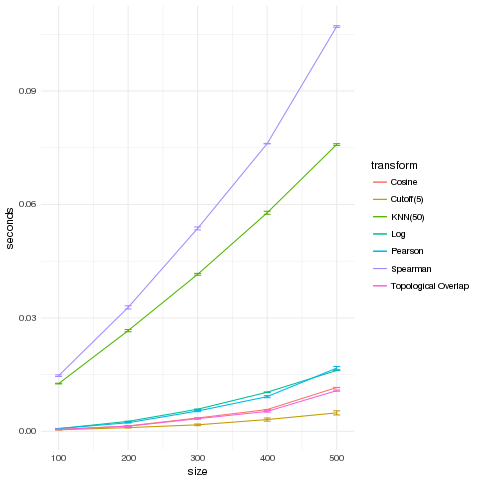

In [25]:
%%R -i frame

g <- ggplot(frame, aes(x=size, y=seconds,group=transform)) + 
    geom_line(aes(color=transform)) + theme_minimal() +
    geom_errorbar(aes(ymin=seconds-error, ymax=seconds+error, color=transform),width=10)
g

In [20]:
%%time
transforms = IndependentVar(
    name='transform',
    values=[KNN(50), TopoOverlap(), Pearson(), Log(), Cutoff(5), Cosine(), Spearman()]
)
res1 = performance_test(transforms, range(100,2700,100))

frame = res1.groupby(['transform', 'size'])
frame = frame['seconds'].agg({'seconds':np.mean, 'error':stats.sem}).reset_index()
frame['error'] = frame['error'] * abs(stats.norm.ppf(0.05/2))



Trials for size 100: 1 2 3 4 5 6 7 8 9 10 
Trials for size 200: 1 2 3 4 5 6 7 8 9 10 
Trials for size 300: 1 2 3 4 5 6 7 8 9 10 
Trials for size 400: 1 2 3 4 5 6 7 8 9 10 
Trials for size 500: 1 2 3 4 5 6 7 8 9 10 
Trials for size 600: 1 2 3 4 5 6 7 8 9 10 
Trials for size 700: 1 2 3 4 5 6 7 8 9 10 
Trials for size 800: 1 2 3 4 5 6 7 8 9 10 
Trials for size 900: 1 2 3 4 5 6 7 8 9 10 
Trials for size 1000: 1 2 3 4 5 6 7 8 9 10 
Trials for size 1100: 1 2 3 4 5 6 7 8 9 10 
Trials for size 1200: 1 2 3 4 5 6 7 8 9 10 
Trials for size 1300: 1 2 3 4 5 6 7 8 9 10 
Trials for size 1400: 1 2 3 4 5 6 7 8 9 10 
Trials for size 1500: 1 2 3 4 5 6 7 8 9 10 
Trials for size 1600: 1 2 3 4 5 6 7 8 9 10 
Trials for size 1700: 1 2 3 4 5 6 7 8 9 10 
Trials for size 1800: 1 2 3 4 5 6 7 8 9 10 
Trials for size 1900: 1 2 3 4 5 6 7 8 9 10 
Trials for size 2000: 1 2 3 4 5 6 7 8 9 10 
Trials for size 2100: 1 2 3 4 5 6 7 8 9 10 
Trials for size 2200: 1 2 3 4 5 6 7 8 9 10 
Trials for size 2300: 1 2 3 4 5 6 7 8 9 

In [21]:
%%R -i frame

g <- ggplot(frame, aes(x=size, y=seconds,group=transform)) + 
    geom_line(aes(color=transform)) + theme_minimal() +
    geom_errorbar(aes(ymin=seconds-error, ymax=seconds+error, color=transform),width=10)
g

In [ ]:
%%time
transforms = IndependentVar(
    name='transform',
    values=[KNN(50), TopoOverlap(), Pearson(), Log(), Cutoff(5), Cosine(), Spearman()]
)
res2 = pd.DataFrame()
for size in range(100,1000,100) + range(1000, 25000, 1000):
    res2 = res2.append(performance_test(transforms, [size]))



Trials for size 100: 1 2 3 4 5 6 7 8 9 10 
Trials for size 200: 1 2 3 4 5 6 7 8 9 10 
Trials for size 300: 1 2 3 4 5 6 7 8 9 10 
Trials for size 400: 1 2 3 4 5 6 7 8 9 10 
Trials for size 500: 1 2 3 4 5 6 7 8 9 10 
Trials for size 600: 1 2 3 4 5 6 7 8 9 10 
Trials for size 700: 1 2 3 4 5 6 7 8 9 10 
Trials for size 800: 1 2 3 4 5 6 7 8 9 10 
Trials for size 900: 1 2 3 4 5 6 7 8 9 10 
Trials for size 1000: 1 2 3 4 5 6 7 8 9 10 
Trials for size 2000: 1 2 3 4 5 6 7 8 9 10 
Trials for size 3000: 1 2 3 4 5 6 7 8 9 10 
Trials for size 4000: 1 2 3 4 5 6 7 8 9 10 
Trials for size 5000: 1 2 3 4 5 6 7

In [ ]:
res2

In [31]:
frame = res2.groupby(['transform', 'size'])
frame = frame['seconds'].agg({'seconds':np.mean, 'error':stats.sem}).reset_index()
frame['error'] = frame['error'] * abs(stats.norm.ppf(0.05/2))
frame = frame[frame['size'] <= 10000]

In [32]:
%%R -i frame

g <- ggplot(frame, aes(x=size, y=seconds,group=transform)) + 
    geom_line(aes(color=transform)) + theme_minimal() +
    geom_errorbar(aes(ymin=seconds-error, ymax=seconds+error, color=transform),width=200)
    
g

Let's try a least-squares polynomial regression on this, to make an estimate of our runtime equation

In [60]:
#res2.to_csv("Transform_Performance_results.tsv", sep='\t', index=False)

In [4]:
#res2 = pd.DataFrame.from_csv("Transform_Performance_results.tsv", sep='\t')

In [6]:
res2['seconds'].sum()

2137.3923773766214

In [81]:
f = res2.groupby(['transform'], as_index=False)
for name, group in f:
    fit = np.polyfit(group['size'], group['seconds'], 3)
    
    print name, np.polyval(fit, 10000), np.polyval(fit, 25000),
    print sum(10*np.polyval(fit, x) for x in range(100,1000,100) + range(1000, 25000, 1000))
#def get_polynomial(group):
#    return np.polyfit(group['size'], group['seconds'], 3)
#f.apply(get_polynomial)

Cutoff(5) 3.52593878382 35.2659410477 2303.96711395
Exponential 7.19151034941 49.5662630455 3725.83179323
KNN(50) 4.7209552974 27.539750805 2174.61420365
Pearson 26.840914507 322.515610261 19937.0169153
Topological Overlap 19.1277319672 232.671772162 14353.4524401


In [84]:
frame2.pivot_table(values='seconds',columns='transform', index='size')

transform  Cutoff(5)  Exponential   KNN(50)    Pearson  Topological Overlap
size                                                                       
100         0.000385     0.000698  0.012514   0.000723             0.000474
200         0.000846     0.002621  0.026341   0.002201             0.001310
300         0.001886     0.005816  0.040758   0.005247             0.003251
400         0.003091     0.010283  0.056507   0.008950             0.005109
500         0.004918     0.016116  0.074572   0.016521             0.010809
600         0.006922     0.023321  0.093731   0.022251             0.013596
700         0.009532     0.032092  0.112709   0.033700             0.021294
800         0.011190     0.042309  0.133468   0.047481             0.027382
900         0.015761     0.054132  0.154111   0.067000             0.037070
1000        0.019160     0.066903  0.175752   0.082571             0.045862
2000        0.102398     0.276973  0.459671   0.496829             0.274895
3000        0.262196     0.633725  0.866285   1.343154             0.793079
4000        0.481032     1.123824  1.255930   2.714744             1.729496
5000        0.718899     1.753652  1.675722   4.509710             2.962471
6000        1.090579     2.524510  2.117909   6.936794             4.705788
7000        1.437470     3.436102  2.600081  10.713555             7.714623
8000        2.078665     4.551260  3.277121  14.866469            10.417480
9000        2.885242     5.817046  4.035520  20.802380            14.642116
10000       3.459986     7.177338  4.699425  26.628558            19.027290

In [86]:
res3 = performance_test(transforms, [25825], trials_per_size=1)

 
Trials for size 25825: 0


In [109]:
res3

transform   size     seconds
0              KNN(50)  25825   17.817294
1  Topological Overlap  25825  273.558042
2              Pearson  25825  330.982839
3          Exponential  25825   48.085193
4            Cutoff(5)  25825   29.762915

In [106]:
res4 = performance_test2(transforms, [100], trials_per_size=2)
frame4 = res4.groupby(['transform', 'size'])
frame4_self = frame4['self_seconds'].agg({'seconds':np.mean, 'error':stats.sem}).reset_index()
frame4_total = frame4['seconds'].agg({'seconds':np.mean, 'error':stats.sem}).reset_index()
#frame4 = frame4['self_seconds'].agg({'self_seconds':np.mean, 'self_error': stats.sem}).reset_index()
#frame4['error'] = frame4['error'] * abs(stats.norm.ppf(0.05/2))
#frame4['self_error'] = frame4['self_error'] * abs(stats.norm.ppf(0.05/2))


Trials for size 100: 1 2


In [108]:
frame4_total

transform  size   seconds     error
0            Cutoff(5)   100  0.000416  0.000006
1          Exponential   100  0.000707  0.000007
2              KNN(50)   100  0.012952  0.000401
3              Pearson   100  0.000791  0.000094
4  Topological Overlap   100  0.000581  0.000109

In [ ]:
%%R -i frame4

g <- ggplot(frame4, aes(x=size, y=self_seconds,group=transform)) + 
    geom_line(aes(color=transform)) + theme_minimal() +
    geom_errorbar(aes(ymin=self_seconds-self_error, ymax=self_seconds+self_error, 
                      color=transform),width=200)
    
g